In [41]:
# Importing necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
# Loading the dataset
data = pd.read_csv('dataset.csv')

In [3]:
#Shape of the dataset. (No of record, columns)
data.shape

(11055, 32)

In [4]:
#Check information regarding columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

In [5]:
# Check if any null values in any features.
if data.isnull().any().sum() == 0:
    print("No features is having null values ")
else:
    print("Some features having null values ")

No features is having null values 


In [6]:
# Dropping index column as it represents unique id for each row
data.drop('index',axis=1,inplace=True)

In [7]:
# Checking number of unique elements in the features.
for col in data.columns:
    print('Column = {}'.format(col))
    print('Unique Count = {}'.format(len(data[col].unique())))
    print('Unique values = {}'.format(data[col].unique()))
    print()

Column = having_IPhaving_IP_Address
Unique Count = 2
Unique values = [-1  1]

Column = URLURL_Length
Unique Count = 3
Unique values = [ 1  0 -1]

Column = Shortining_Service
Unique Count = 2
Unique values = [ 1 -1]

Column = having_At_Symbol
Unique Count = 2
Unique values = [ 1 -1]

Column = double_slash_redirecting
Unique Count = 2
Unique values = [-1  1]

Column = Prefix_Suffix
Unique Count = 2
Unique values = [-1  1]

Column = having_Sub_Domain
Unique Count = 3
Unique values = [-1  0  1]

Column = SSLfinal_State
Unique Count = 3
Unique values = [-1  1  0]

Column = Domain_registeration_length
Unique Count = 2
Unique values = [-1  1]

Column = Favicon
Unique Count = 2
Unique values = [ 1 -1]

Column = port
Unique Count = 2
Unique values = [ 1 -1]

Column = HTTPS_token
Unique Count = 2
Unique values = [-1  1]

Column = Request_URL
Unique Count = 2
Unique values = [ 1 -1]

Column = URL_of_Anchor
Unique Count = 3
Unique values = [-1  0  1]

Column = Links_in_tags
Unique Count = 3
Unique

#### EDA

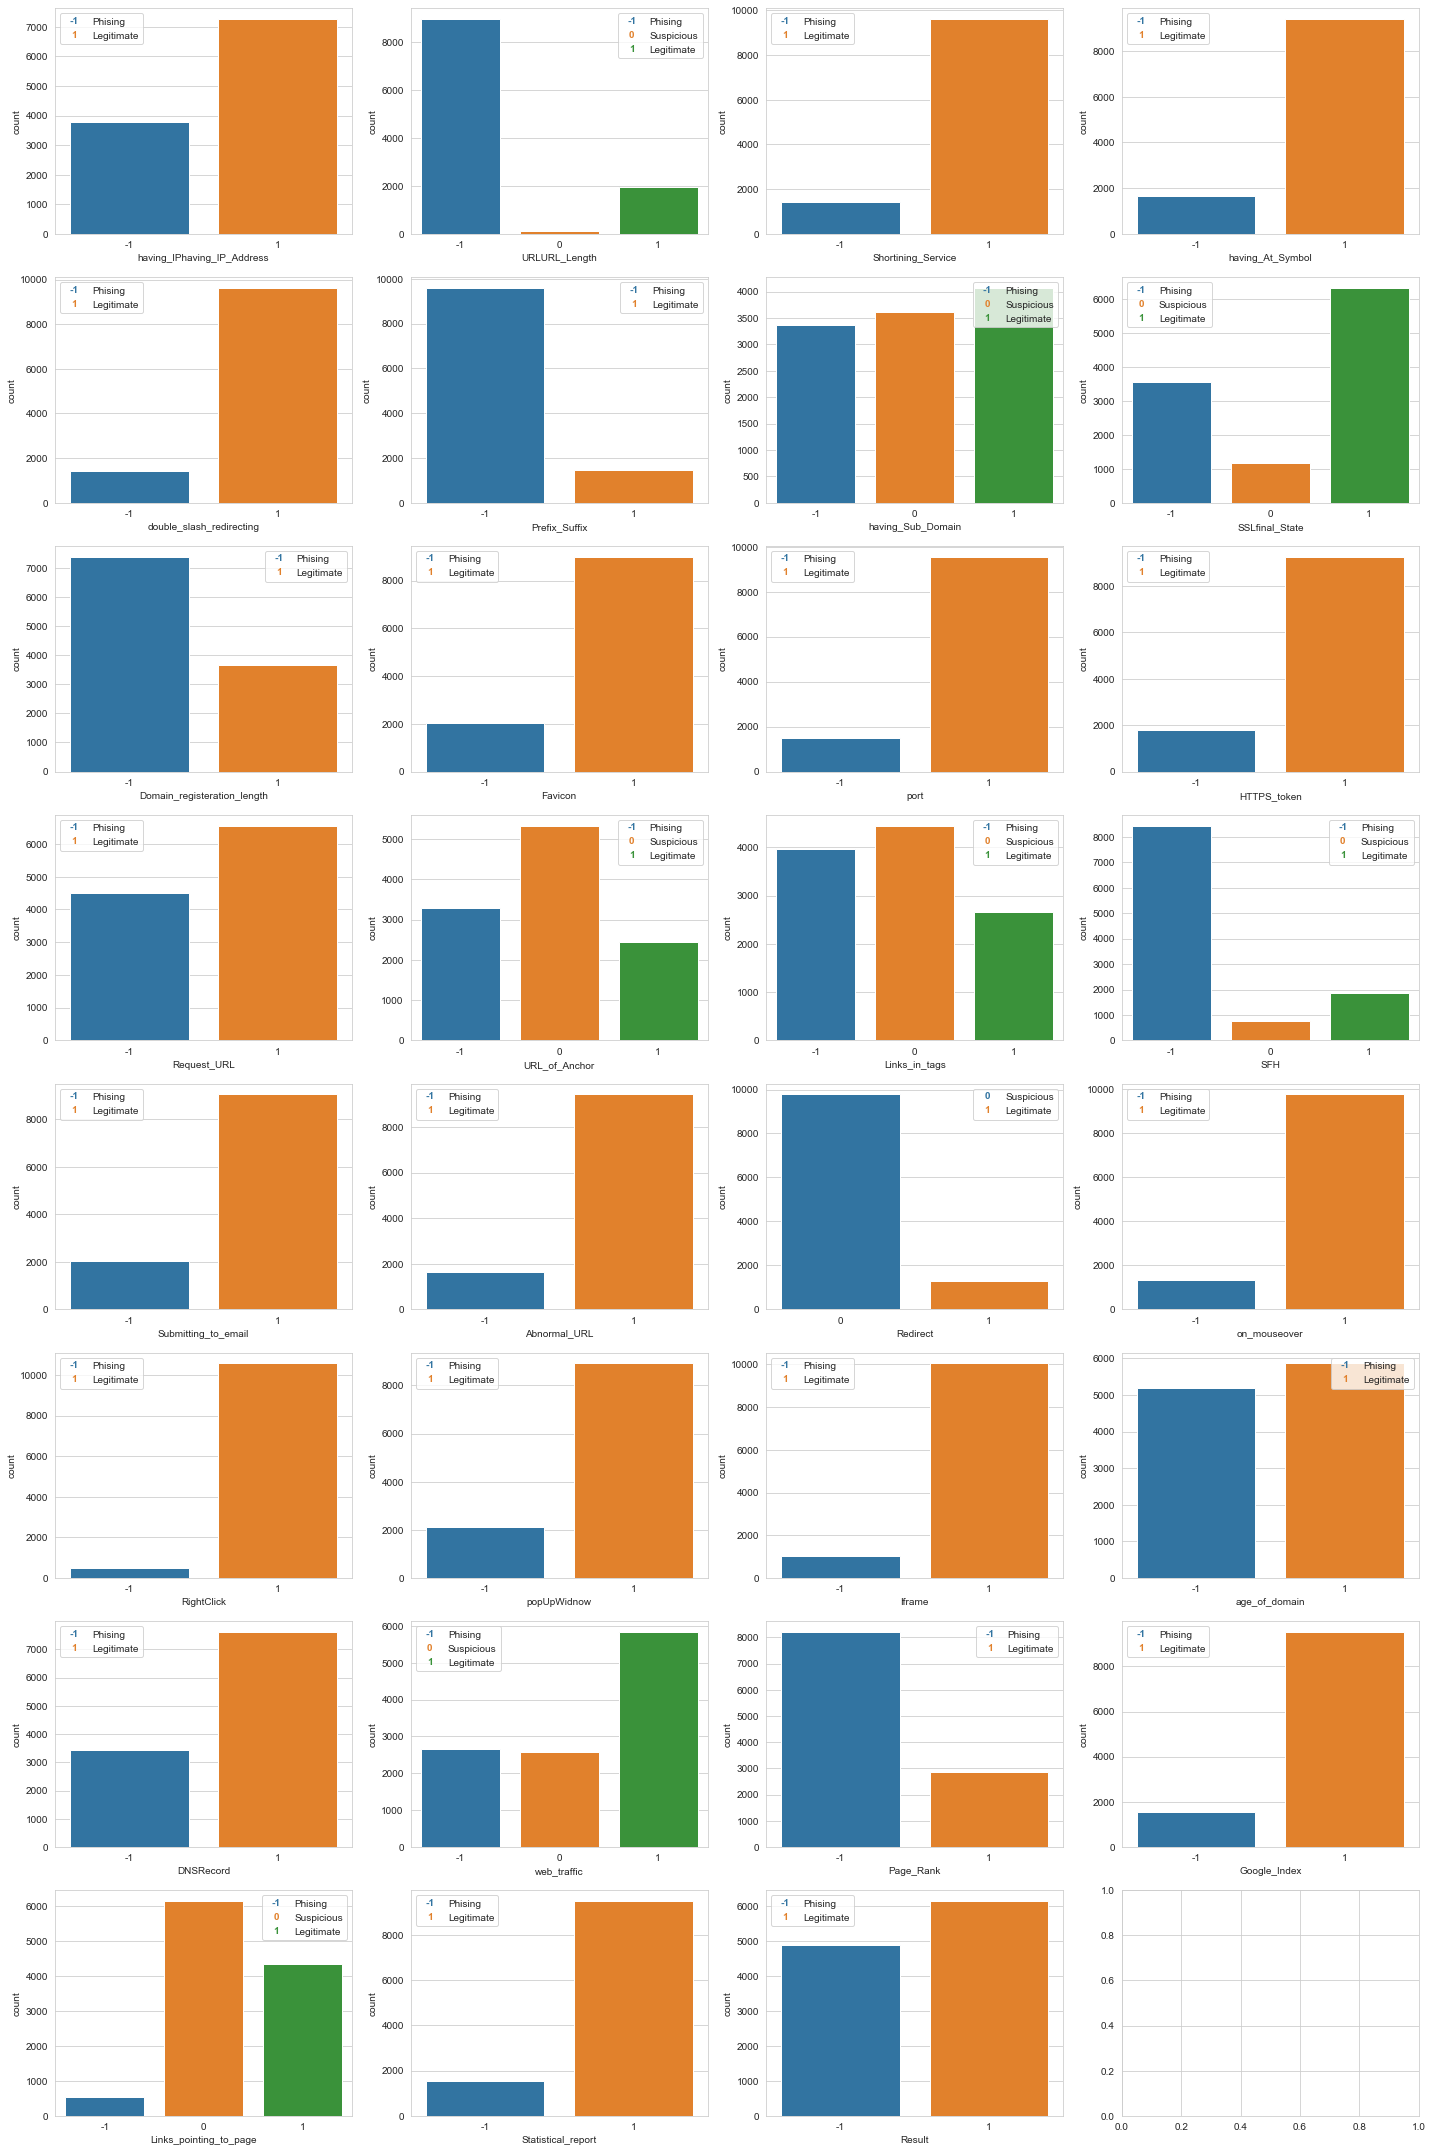

In [43]:
# Functions to add legend names for proper representation and reading
#
# Plotting count plot for each attributes to check distribution of URL description
# -1 : Phising
# 0 : Suspicious
# 1 : Legitimate


class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]

def legendCreaton(ax):

    handltext = ['-1','0','1']
    labels = ["Phising", "Suspicious", "Legitimate"]

    t = ax.get_xticklabels()
    labeldic = dict(zip(handltext, labels))
    labels = [labeldic[h.get_text()]  for h in t]
    handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]

    ax.legend(handles, labels, handler_map={tuple : TextHandler()})
    


fig, axes = plt.subplots(8, 4, figsize=(20, 30),squeeze=False,)
sns.set_style("whitegrid")
x,y=0,0
for col in data.columns:
    sns.countplot(data=data,x=col,ax=axes[x,y])
    legendCreaton(axes[x,y])
    if y < 3:
        y+=1
    else:
        x+=1
        y=0
fig.tight_layout()

# Save the figure
fig.savefig('Histogram.jpeg')

In [10]:
# Checking relationship between features and label variables
# 
# Filter out the features which are having no relationship with feature and label, 
# considering SL value as 0.05

SL = 0.05
selected_feature = []

features = data.drop('Result',axis=1)
lable = data.Result

from scipy.stats import chi2_contingency

for col in features.columns:
    c_t = pd.crosstab(features[col],lable)
    _,pvalue,_,_ = chi2_contingency(c_t)
    
    if pvalue <= SL:
        print("{} and {} have some form of relationship".format(col,'Result'))
        selected_feature.append(col)
    else:
        print("{} and {} have no relationship".format(col,'Result'))

having_IPhaving_IP_Address and Result have some form of relationship
URLURL_Length and Result have some form of relationship
Shortining_Service and Result have some form of relationship
having_At_Symbol and Result have some form of relationship
double_slash_redirecting and Result have some form of relationship
Prefix_Suffix and Result have some form of relationship
having_Sub_Domain and Result have some form of relationship
SSLfinal_State and Result have some form of relationship
Domain_registeration_length and Result have some form of relationship
Favicon and Result have no relationship
port and Result have some form of relationship
HTTPS_token and Result have some form of relationship
Request_URL and Result have some form of relationship
URL_of_Anchor and Result have some form of relationship
Links_in_tags and Result have some form of relationship
SFH and Result have some form of relationship
Submitting_to_email and Result have no relationship
Abnormal_URL and Result have some form o

In [11]:
# Filtering dataframe with selected features that is having some form of relationship 
# with target variable based on choosen CL value

features_selected = data[selected_feature]
label = data.Result

### Model Building

In [12]:
## Creating empty data frame to capture accuracy and other metrics for different classification models
model_metrics = pd.DataFrame(columns=['Model','Accuracy(Train)','Accuracy(Test)'])

In [13]:
## Creating train and test data
X_train,X_test,y_train,y_test = train_test_split(features_selected,label,test_size=0.2,random_state=100)

#### 1. Logistic Regression

In [14]:
## 1. Build Logistic Regression model
## 2. Checking the accuracy of train and test data
## 3. Storing accuracy data in model_metrics dataframe

lr = LogisticRegression()
lr.fit(X_train,y_train)

predict_train_data = lr.predict(X_train)
predict_test_data = lr.predict(X_test)

temp_dict = {}
temp_dict['Model']='Logistic Regression' 
temp_dict['Accuracy(Train)'] = accuracy_score(y_train,predict_train_data)
temp_dict['Accuracy(Test)'] = accuracy_score(y_test,predict_test_data)


if temp_dict['Model'] in model_metrics.Model.values:
    model_metrics.drop(model_metrics[model_metrics.Model == temp_dict['Model']].index,inplace=True)
    
model_metrics = model_metrics.append(temp_dict,ignore_index=True)

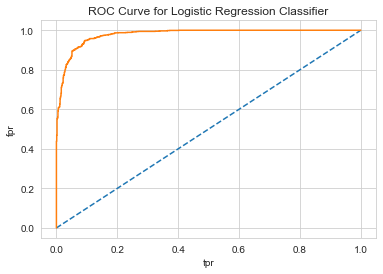

In [49]:
# ROC curve showing diagnostic ability of Logistic Regression classifier

probValues = lr.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test,probValues)

plt.plot([0,1],[0,1],linestyle='--')

fpr,tpr,_ = roc_curve(y_test,probValues)

plt.plot(fpr,tpr)
plt.title("ROC Curve for Logistic Regression Classifier")
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.savefig("ROC_Curve_Logistic_Regression.jpeg")
plt.show()

In [16]:
## 1. Build Decision Tree model
## 2. Checking the accuracy of train and test data
## 3. Storing accuracy data in model_metrics dataframe

dt = DecisionTreeClassifier(max_depth=15,criterion='entropy')
dt.fit(X_train,y_train)

predict_train_data = dt.predict(X_train)
predict_test_data = dt.predict(X_test)

temp_dict = {}
temp_dict['Model']='Decision Tree' 
temp_dict['Accuracy(Train)'] = accuracy_score(y_train,predict_train_data)
temp_dict['Accuracy(Test)'] = accuracy_score(y_test,predict_test_data)

if temp_dict['Model'] in model_metrics.Model.values:
    model_metrics.drop(model_metrics[model_metrics.Model == temp_dict['Model']].index,inplace=True)

model_metrics = model_metrics.append(temp_dict,ignore_index=True)

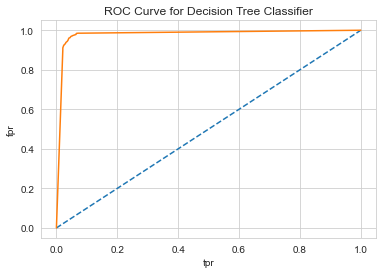

In [46]:
# ROC curve showing diagnostic ability of Decision Tree classifier

probValues = dt.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test,probValues)

plt.plot([0,1],[0,1],linestyle='--')

fpr,tpr,_ = roc_curve(y_test,probValues)

plt.plot(fpr,tpr)
plt.title("ROC Curve for Decision Tree Classifier")
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.savefig("ROC_Curve_Decision_Tree.jpeg")
plt.show()

In [18]:
## 1. Build Random Forest Classifier model
## 2. Checking the accuracy of train and test data
## 3. Storing accuracy data in model_metrics dataframe

rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train,y_train)

predict_train_data = rf.predict(X_train)
predict_test_data = rf.predict(X_test)

temp_dict = {}
temp_dict['Model']='Random Forest' 
temp_dict['Accuracy(Train)'] = accuracy_score(y_train,predict_train_data)
temp_dict['Accuracy(Test)'] = accuracy_score(y_test,predict_test_data)

if temp_dict['Model'] in model_metrics.Model.values:
    model_metrics.drop(model_metrics[model_metrics.Model == temp_dict['Model']].index,inplace=True)

model_metrics = model_metrics.append(temp_dict,ignore_index=True)

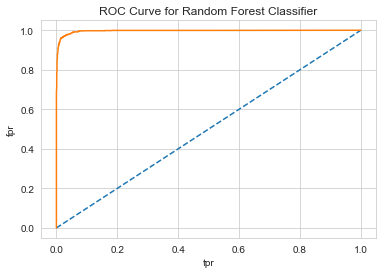

In [47]:
# ROC curve showing diagnostic ability of Random Forest classifier

probValues = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test,probValues)

plt.plot([0,1],[0,1],linestyle='--')

fpr,tpr,_ = roc_curve(y_test,probValues)

plt.plot(fpr,tpr)
plt.title("ROC Curve for Random Forest Classifier")
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.savefig("ROC_Curve_Random_Forest.jpeg")
plt.show()

In [20]:
## 1. Build XGBoost Classifier model
## 2. Checking the accuracy of train and test data
## 3. Storing accuracy data in model_metrics dataframe

xgb = XGBClassifier(n_estimators=100)
xgb.fit(X_train,y_train)

predict_train_data = xgb.predict(X_train)
predict_test_data = xgb.predict(X_test)

temp_dict = {}
temp_dict['Model']='XG Boost' 
temp_dict['Accuracy(Train)'] = accuracy_score(y_train,predict_train_data)
temp_dict['Accuracy(Test)'] = accuracy_score(y_test,predict_test_data)

if temp_dict['Model'] in model_metrics.Model.values:
    model_metrics.drop(model_metrics[model_metrics.Model == temp_dict['Model']].index,inplace=True)

model_metrics = model_metrics.append(temp_dict,ignore_index=True)

C:\Users\91900\anaconda3\envs\ML_Env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


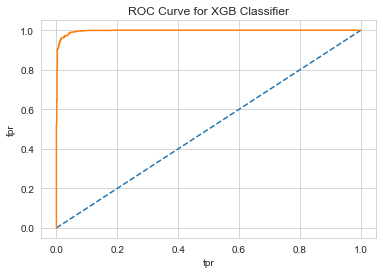

In [48]:
# ROC curve showing diagnostic ability of XGB classifier

probValues = xgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test,probValues)

plt.plot([0,1],[0,1],linestyle='--')

fpr,tpr,_ = roc_curve(y_test,probValues)

plt.plot(fpr,tpr)
plt.title("ROC Curve for XGB Classifier")
plt.xlabel("tpr")
plt.ylabel("fpr")
plt.savefig("ROC_Curve_XGB.jpeg")
plt.show()

#### K-Fold Cross Validation

In [22]:
## Function to perform KFold Cross Validation
def KFoldValidation(model,X,y,scoring):
    
    kfold = KFold(shuffle=True)
    scores = cross_val_score(model,X,y,cv=kfold,scoring=scoring)
    
    return (np.mean(scores),np.var(scores))

In [23]:
## Adding two new columns to model_metrics to capture cross validation results
model_metrics['KFold Cross Vaidation (Mean)']=np.nan
model_metrics['KFold Cross Vaidation (Variance)']=np.nan

In [40]:
## Capturing cross validation results for each of the 4 classification models
## Metrics Captured = Mean and Variance of Cross validation score

lr_score = KFoldValidation(lr,features_selected,label,'accuracy')
model_metrics.at[model_metrics[model_metrics.Model == 'Logistic Regression'].index[0],'KFold Cross Vaidation (Mean)']=lr_score[0]
model_metrics.at[model_metrics[model_metrics.Model == 'Logistic Regression'].index[0],'KFold Cross Vaidation (Variance)']=lr_score[1]


dt_score = KFoldValidation(dt,features_selected,label,'accuracy')
model_metrics.at[model_metrics[model_metrics.Model == 'Decision Tree'].index[0],'KFold Cross Vaidation (Mean)']=dt_score[0]
model_metrics.at[model_metrics[model_metrics.Model == 'Decision Tree'].index[0],'KFold Cross Vaidation (Variance)']=dt_score[1]


rf_score = KFoldValidation(rf,features_selected,label,'accuracy')
model_metrics.at[model_metrics[model_metrics.Model == 'Random Forest'].index[0],'KFold Cross Vaidation (Mean)']=rf_score[0]
model_metrics.at[model_metrics[model_metrics.Model == 'Random Forest'].index[0],'KFold Cross Vaidation (Variance)']=rf_score[1]


xgb_score = KFoldValidation(xgb,features_selected,label,'accuracy')
model_metrics.at[model_metrics[model_metrics.Model == 'XG Boost'].index[0],'KFold Cross Vaidation (Mean)']=xgb_score[0]
model_metrics.at[model_metrics[model_metrics.Model == 'XG Boost'].index[0],'KFold Cross Vaidation (Variance)']=xgb_score[1]

[22:15:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:15:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [36]:
## Display model_metrics containing all the metrics captured
## This will help deciding which model performs well on the dataset

model_metrics

,Model,Accuracy(Train),Accuracy(Test),KFold Cross Vaidation (Mean),KFold Cross Vaidation (Variance)
0,Logistic Regression,0.928200,0.924921,0.927815,0.000021
1,Decision Tree,0.981456,0.959294,0.958390,0.000013
2,Random Forest,0.989711,0.971506,0.970602,0.000001
3,XG Boost,0.985640,0.969697,0.971325,0.000007


Conclusion : 
    As per above metrics both Random Forest and XGBoost Classification model gives good
    result. We will choose Random Forest model as we are getting less variance in cross Validation.

In [37]:
## Save the Random Forest model and Feature Selected.
## 
## We can create seprate python script where we will load this two saved files 
## and do the predictions for any URL.

import joblib

# Random Forest Model
joblib.dump(rf,'finalized_model.sav')

# Attributes used to build the model
joblib.dump(features_selected.columns,'selected_features.sav')

['selected_features.sav']